In [1]:
import numpy as np 
from utils_1d import offline_opt 
from utils_1d import best_linear
from utils_1d import vis
import matplotlib.pyplot as plt

Implement R-OBD controller for 1-d system.

The dynamics is
$$x_{t+1} = a x_t + u_t + w_t.$$

The cost is
$$\sum_{t=0}^Tq|x_t|^2+|u_t|^2$$

Define 
$$y_t = a y_{t-1} + u_t,$$
where $y_{-1} = 0$.

Define
$$z_t = a z_{t-1} + w_t,$$
where $z_{-1} = x_0$.

Notice that after defining $y_t$ and $z_t$, we can represent $x_{t+1}$ as
$$x_{t+1}=y_t+z_t.$$

Then we can transform the online control problem to an online optimization with memory, where hitting cost is $f_t(y) = q(y + z_t)^2$ and the switching cost is $c(y) = (y - ay_{t-1})^2$.

After solving $y_t$, we use
$$u_t = y_t - a y_{t-1}$$
to determine the control action $u_t$.

In [2]:
class ROBD_Controller:
    def __init__(self, x0, a, Q, lambda_1, lambda_2=0.0, epsilon=0.0, Optimistic=False, Smooth=True):
        '''
        ROBD:       Optimistic=False
        Op-ROBD:    Optimistic=True
        If Smooth=True, the estimation set W_t = w_{t-1} + (-epsilon, epsilon)
        If Smooth=False, the estimation set W_t = (-epsilon, epsilon)
        '''
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        self.Optimistic = Optimistic
        self.Smooth = Smooth
        self.epsilon = epsilon
        self.a = a
        self.Q = Q
        self.x = [x0]
        self.u = [0.0]
        self.y = [0.0] #for convenience, we query y_t by index, self.y=[y_{t-1}, y_{t-2}]
        self.noisy_y = [0.0] #This is a noisy estimation of accurate y
        self.z = [x0] #for convenience, we query z_t by index
        self.w_seq = [0.0] #noise sequence
        self.trace = []
    def ROBD(self, z, y):
        temp = self.Q*z + self.lambda_1*(-self.a*y) + self.lambda_2*z
        return - temp / (self.Q + self.lambda_1 + self.lambda_2)
    
    #Tell the current state to the algorithm, ask it to determine the control action
    def query(self, state, w_next=0, w_prev=0, shift=True):
        if(len(self.x) >= 2): #we do not compute the noise when the game begins
            last_w = w_prev #get the last time step's w 
            self.w_seq.append(last_w) #record the last noise
        self.x.append(state)
        
        if(len(self.x) >= 3):
            #First, calculate the accurate y_{t-1} using the knowledge of accurate w_{t-1}
            last_z = self.a * self.z[-1] + self.w_seq[-1]
            last_y = self.ROBD(last_z, self.y[-1]) #Oracle ROBD's action
            
            # To deal with the numerical issue (see Apendix G)
            # note that x_{t+1} = y_t + z_t = y_t - c + z_t + c and we can take the following translation!
            if np.abs(last_z) > 50.0 and shift:
                last_y += last_z
                self.noisy_y[-1] += last_z
                last_z = 0.0
            # note that x_{t+1} (state) should exactly match with y_t + z_t
            self.noisy_y[-1] = state - last_z
            
            self.z.append(last_z)
            self.y.append(last_y)   
                
        #Next, use w_{t-1} as an estimation of w_t and calculate u_t
        if not self.Optimistic:
            last_z = self.a * self.z[-1] + w_next # ROBD
            last_y = self.ROBD(last_z, self.y[-1])
        else:
            # If smooth, | z - (self.a * self.z[-1] + self.w_seq[-1]) | < epsilon
            # If not smooth, | z - a * self.z[-1] | < epsilon
            if self.Smooth:
                last_z = self.a * self.z[-1] + self.w_seq[-1]
            else:
                last_z = self.a * self.z[-1]
            stationary_y = -self.a * self.y[-1]
            if(stationary_y < last_z - self.epsilon):
                last_z -= self.epsilon
            elif(stationary_y > last_z + self.epsilon):
                last_z += self.epsilon
            else:
                last_z = stationary_y
            last_y = self.ROBD(last_z, self.y[-1])
            
        last_u = last_y - self.a * self.noisy_y[-1]
        self.noisy_y.append(last_y)
        self.u.append(last_u)
        
        return last_u
    
    #Calculate the total cost of ROBD on a sequence of noise w_t
    def total_cost(self, noise_seq, x0, T, shift=True):
        total = 0.0
        state = x0
        self.trace = [x0]
        for t in range(T):
            control_action = self.query(state, w_next=noise_seq[t], w_prev=noise_seq[t-1], shift=shift) #query the control action
            state = self.a * state + control_action + noise_seq[t] #evolve
            total += self.Q * state**2
            total += control_action**2
            self.trace.append(state)
        return total

In [3]:
T = 200
x0 = 0.0
q = 8.0
a = 2.0

cost(OPT) = 40.10400377446631
cost(LC) = 719.2447077315862
K* = 1.8088088088088088
cost(LC)/cost(OPT) = 17.93448633648693


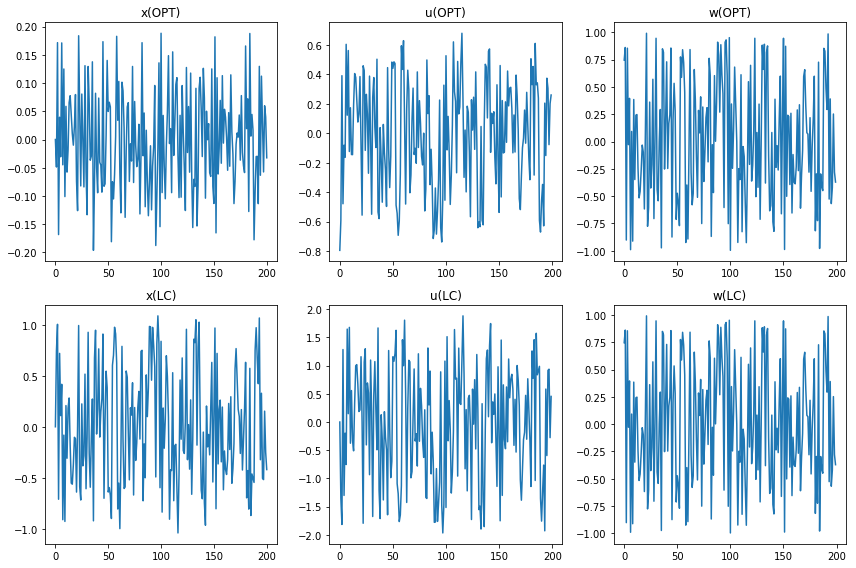

In [4]:
# Random w
w = 2 * (np.random.uniform(size=T) - 0.5)

x_opt, u_opt, loss_opt = offline_opt(x0, q, a, T, w)
K_opt, loss_lc, x_lc, u_lc = best_linear(x0, q, T, a, w)
print('cost(OPT) =', loss_opt)
print('cost(LC) =', loss_lc)
print('K* =', K_opt)
print('cost(LC)/cost(OPT) =', loss_lc/loss_opt)

vis([[x_opt, u_opt, w], [x_lc, u_lc, w]], ['OPT', 'LC'])

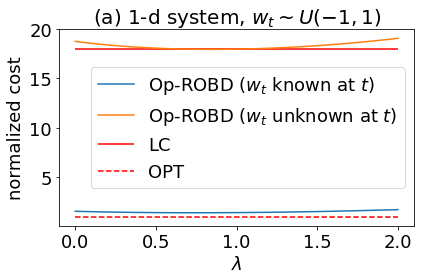

cost(OPT) = 40.10400377446631
cost(LC) = 719.2447077315862
K* = 1.8088088088088088
cost(LC)/cost(OPT) = 17.93448633648693
ROBD: The minimum cost is: 56.80102336634268  achieved at lambda =  0.7437185929648241
Op_ROBD: The minimum cost is: 719.2449108543454  achieved at lambda =  0.8442211055276382


In [5]:
lam = np.linspace(0, 2, 200)
ROBD = []
Op_ROBD = []
for l in lam:
    ROBD_instance = ROBD_Controller(x0=x0, a=a, Q=q, lambda_1=l, lambda_2=0.0)
    ROBD_cost = ROBD_instance.total_cost(w, x0=x0, T=T)
    
    Op_ROBD_instance = ROBD_Controller(x0=x0, a=a, Q=q, lambda_1=l, lambda_2=0.0, epsilon=1.0, Optimistic=True, Smooth=False)
    Op_ROBD_cost = Op_ROBD_instance.total_cost(w, x0=x0, T=T)
    
    ROBD.append(ROBD_cost)
    Op_ROBD.append(Op_ROBD_cost)

plt.plot(lam, ROBD/loss_opt)
plt.plot(lam, Op_ROBD/loss_opt)
plt.hlines(y=loss_lc/loss_opt, xmin=lam[0], xmax=lam[-1], colors='r')
plt.hlines(y=loss_opt/loss_opt, xmin=lam[0], xmax=lam[-1], colors='r', linestyles='--')
plt.legend([r'Op-ROBD ($w_t$ known at $t$)', r'Op-ROBD ($w_t$ unknown at $t$)', 'LC', 'OPT'], fontsize=18)
plt.xlabel(r'$\lambda$', fontsize=18)
plt.ylabel('normalized cost', fontsize=18)
plt.tick_params(labelsize=18)
plt.title(r'(a) 1-d system, $w_t\sim U(-1,1)$', fontsize=20)
plt.tight_layout()
#plt.savefig('random_1d.pdf')
plt.show()

print('cost(OPT) =', loss_opt)
print('cost(LC) =', loss_lc)
print('K* =', K_opt)
print('cost(LC)/cost(OPT) =', loss_lc/loss_opt)
print("ROBD: The minimum cost is:", np.min(ROBD), " achieved at lambda = ", lam[np.argmin(ROBD)])
print("Op_ROBD: The minimum cost is:", np.min(Op_ROBD), " achieved at lambda = ", lam[np.argmin(Op_ROBD)])

cost(OPT) = 236.782429461645
cost(LC) = 1276.7882874463162
K* = 2.921921921921922
cost(LC)/cost(OPT) = 5.392242533997378


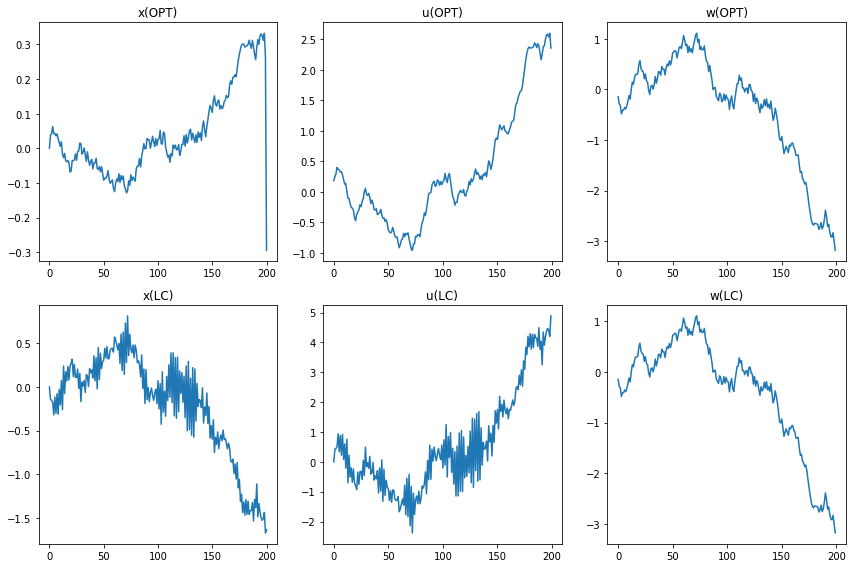

In [6]:
# Random walk w
temp = 0.4 * (np.random.uniform(size=T+1) - 0.5)
for t in range(T):
    w[t] = np.sum(temp[:t+1])
        
x_opt, u_opt, loss_opt = offline_opt(x0, q, a, T, w)
K_opt, loss_lc, x_lc, u_lc = best_linear(x0, q, T, a, w)
print('cost(OPT) =', loss_opt)
print('cost(LC) =', loss_lc)
print('K* =', K_opt)
print('cost(LC)/cost(OPT) =', loss_lc/loss_opt)

vis([[x_opt, u_opt, w], [x_lc, u_lc, w]], ['OPT', 'LC'])

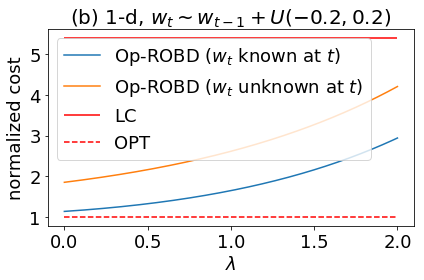

cost(OPT) = 236.782429461645
cost(LC) = 1276.7882874463162
K* = 2.921921921921922
cost(LC)/cost(OPT) = 5.392242533997378
ROBD: The minimum cost is: 268.6365688017216  achieved at lambda =  0.0
Op_ROBD: The minimum cost is: 438.13737017087874  achieved at lambda =  0.0


In [7]:
lam = np.linspace(0, 2, 200)
ROBD = []
Op_ROBD = []
for l in lam:
    ROBD_instance = ROBD_Controller(x0=x0, a=a, Q=q, lambda_1=l, lambda_2=0.0)
    ROBD_cost = ROBD_instance.total_cost(w, x0=x0, T=T)
    
    Op_ROBD_instance = ROBD_Controller(x0=x0, a=a, Q=q, lambda_1=l, lambda_2=0.0, epsilon=0.2, Optimistic=True, Smooth=True)
    Op_ROBD_cost = Op_ROBD_instance.total_cost(w, x0=x0, T=T)
    
    ROBD.append(ROBD_cost)
    Op_ROBD.append(Op_ROBD_cost)

plt.plot(lam, ROBD/loss_opt)
plt.plot(lam, Op_ROBD/loss_opt)
plt.hlines(y=loss_lc/loss_opt, xmin=lam[0], xmax=lam[-1], colors='r')
plt.hlines(y=loss_opt/loss_opt, xmin=lam[0], xmax=lam[-1], colors='r', linestyles='--')
plt.legend([r'Op-ROBD ($w_t$ known at $t$)', r'Op-ROBD ($w_t$ unknown at $t$)', 'LC', 'OPT'], fontsize=18)
plt.xlabel(r'$\lambda$', fontsize=18)
plt.ylabel('normalized cost', fontsize=18)
plt.tick_params(labelsize=18)
plt.title(r'(b) 1-d, $w_t\sim w_{t-1}+U(-0.2,0.2)$', fontsize=20)
plt.tight_layout()
#plt.savefig('random_1d.pdf')
plt.show()

print('cost(OPT) =', loss_opt)
print('cost(LC) =', loss_lc)
print('K* =', K_opt)
print('cost(LC)/cost(OPT) =', loss_lc/loss_opt)
print("ROBD: The minimum cost is:", np.min(ROBD), " achieved at lambda = ", lam[np.argmin(ROBD)])
print("Op_ROBD: The minimum cost is:", np.min(Op_ROBD), " achieved at lambda = ", lam[np.argmin(Op_ROBD)])